# DC IR analysis

This example shows how to configure EDB for DC IR analysis and load EDB into the HFSS 3D Layout UI for analysis and
postprocessing.

- Set up EDB:

    - Edit via padstack.
    - Assign SPICE model to components.
    - Create pin groups.
    - Create voltage and current sources.
    - Create SIwave DC analysis.
    - Create cutout.

- Import EDB into HFSS 3D Layout:

    - Analyze.
    - Get DC IR analysis results.

Keywords: **HFSS 3D Layout**, **DC IR**.

## Perform imports and define constants
Perform required imports.

In [1]:
import json
import os
import tempfile
import time

In [2]:
import ansys.aedt.core
from ansys.aedt.core.examples.downloads import download_file
from pyedb import Edb

Define constants.

In [3]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

Download example board.

In [4]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")
aedb = download_file(source="edb/ANSYS-HSD_V1.aedb", local_path=temp_folder.name)
_ = download_file(
    source="spice", name="ferrite_bead_BLM15BX750SZ1.mod", local_path=temp_folder.name
)

## Create configuration file
This example uses a configuration file to set up the layout for analysis.
Initialize and create an empty dictionary to host all configurations.

In [5]:
cfg = dict()

Define model library paths.

In [6]:
cfg["general"] = {
    "s_parameter_library": os.path.join(temp_folder.name, "touchstone"),
    "spice_model_library": os.path.join(temp_folder.name, "spice"),
}

### Change via hole size and plating thickness

In [7]:
cfg["padstacks"] = {
    "definitions": [
        {"name": "v40h15-3", "hole_diameter": "0.2mm", "hole_plating_thickness": "25um"}
    ],
}

### Assign SPICE models

In [8]:
cfg["spice_models"] = [
    {
        "name": "ferrite_bead_BLM15BX750SZ1",  # Give a name to the SPICE Mode.
        "component_definition": "COIL-1008CS_V",  # Part name of the components
        "file_path": "ferrite_bead_BLM15BX750SZ1.mod",  # File name or full file path to the SPICE file.
        "sub_circuit_name": "BLM15BX750SZ1",
        "apply_to_all": True,  # If True, SPICE model is to be assigned to all components share the same part name.
        # If False, only assign SPICE model to components in "components".
        "components": [],
    }
]

### Create voltage source
Create a voltage source from a net.

In [9]:
cfg["sources"] = [
    {
        "name": "VSOURCE_5V",
        "reference_designator": "U4",
        "type": "voltage",
        "magnitude": 5,
        "positive_terminal": {"net": "5V"},
        "negative_terminal": {"net": "GND"},
    }
]

### Create current sources
Create current sources between the net and pin group.

In [10]:
cfg["pin_groups"] = [{"name": "J5_GND", "reference_designator": "J5", "net": "GND"}]

In [11]:
cfg["sources"].append(
    {
        "name": "J5_VCCR",
        "reference_designator": "J5",
        "type": "current",
        "magnitude": 0.5,
        "positive_terminal": {"net": "SFPA_VCCR"},
        "negative_terminal": {
            "pin_group": "J5_GND"  # Defined in "pin_groups" section.
        },
    }
)
cfg["sources"].append(
    {
        "name": "J5_VCCT",
        "reference_designator": "J5",
        "type": "current",
        "magnitude": 0.5,
        "positive_terminal": {"net": "SFPA_VCCT"},
        "negative_terminal": {
            "pin_group": "J5_GND"  # Defined in "pin_groups" section.
        },
    }
)

### Create SIwave DC analysis

In [12]:
cfg["setups"] = [{"name": "siwave_dc", "type": "siwave_dc", "dc_slider_position": 0}]

### Define cutout

In [13]:
cfg["operations"] = {
    "cutout": {
        "signal_list": ["SFPA_VCCR", "SFPA_VCCT", "5V"],
        "reference_list": ["GND"],
        "extent_type": "ConvexHull",
        "expansion_size": 0.002,
        "use_round_corner": False,
        "output_aedb_path": "",
        "open_cutout_at_end": True,
        "use_pyaedt_cutout": True,
        "number_of_threads": 4,
        "use_pyaedt_extent_computing": True,
        "extent_defeature": 0,
        "remove_single_pin_components": False,
        "custom_extent": "",
        "custom_extent_units": "mm",
        "include_partial_instances": False,
        "keep_voids": True,
        "check_terminals": False,
        "include_pingroups": False,
        "expansion_factor": 0,
        "maximum_iterations": 10,
        "preserve_components_with_model": False,
        "simple_pad_check": True,
        "keep_lines_as_path": False,
    }
}

### Save configuration as a JSON file

In [14]:
pi_json = os.path.join(temp_folder.name, "pi.json")
with open(pi_json, "w") as f:
    json.dump(cfg, f, indent=4, ensure_ascii=False)

## Load configuration into EDB

Load the configuration from the JSON file into EDB.

In [15]:
edbapp = Edb(aedb, edbversion=AEDT_VERSION)
edbapp.configuration.load(config_file=pi_json)
edbapp.configuration.run()

C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `edbversion` is deprecated for method `Edb`; use `version` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)


PyEDB INFO: Star initializing Edb 05:25:05.401036


INFO:Edb:Star initializing Edb 05:25:05.401036


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


INFO:Edb:Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 9.1130 seconds.


INFO:Edb:open_edb completed in 9.1130 seconds.


PyEDB INFO: EDB initialization completed in 9.1928 seconds.


INFO:Edb:EDB initialization completed in 9.1928 seconds.


PyEDB INFO: Updating boundaries finished. Time lapse 0:00:00.015876


INFO:Edb:Updating boundaries finished. Time lapse 0:00:00.015876


PyEDB INFO: Updating nets finished. Time lapse 0:00:00


INFO:Edb:Updating nets finished. Time lapse 0:00:00


PyEDB INFO: Updating components finished. Time lapse 0:00:00


INFO:Edb:Updating components finished. Time lapse 0:00:00


PyEDB INFO: Creating pin groups finished. Time lapse 0:00:00.015658


INFO:Edb:Creating pin groups finished. Time lapse 0:00:00.015658


PyEDB INFO: Placing sources finished. Time lapse 0:00:00.063356


INFO:Edb:Placing sources finished. Time lapse 0:00:00.063356


PyEDB INFO: Applying materials finished. Time lapse 0:00:00


INFO:Edb:Applying materials finished. Time lapse 0:00:00


PyEDB INFO: Updating stackup finished. Time lapse 0:00:00


INFO:Edb:Updating stackup finished. Time lapse 0:00:00


PyEDB INFO: Applying padstacks finished. Time lapse 0:00:00


INFO:Edb:Applying padstacks finished. Time lapse 0:00:00


PyEDB INFO: Applying S-parameters finished. Time lapse 0:00:00


INFO:Edb:Applying S-parameters finished. Time lapse 0:00:00


PyEDB INFO: Assigning Spice model <pyedb.configuration.cfg_spice_models.CfgSpiceModel object at 0x000002001867DD80> finished. Time lapse 0:00:00.032214


INFO:Edb:Assigning Spice model <pyedb.configuration.cfg_spice_models.CfgSpiceModel object at 0x000002001867DD80> finished. Time lapse 0:00:00.032214


PyEDB INFO: Applying package definitions finished. Time lapse 0:00:00


INFO:Edb:Applying package definitions finished. Time lapse 0:00:00


PyEDB INFO: Applying modeler finished. Time lapse 0:00:00


INFO:Edb:Applying modeler finished. Time lapse 0:00:00


PyEDB INFO: Placing ports finished. Time lapse 0:00:00


INFO:Edb:Placing ports finished. Time lapse 0:00:00


PyEDB INFO: Placing terminals completed in 0.0000 seconds.


INFO:Edb:Placing terminals completed in 0.0000 seconds.


PyEDB INFO: Placing probes finished. Time lapse 0:00:00


INFO:Edb:Placing probes finished. Time lapse 0:00:00


PyEDB INFO: -----------------------------------------


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `signal_list` is deprecated for method `cutout`; use `signal_nets` instead.
  warnings.warn(
C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\misc\decorators.py:55: UserWarning: Argument `reference_list` is deprecated for method `cutout`; use `reference_nets` instead.
  warnings.warn(
INFO:Edb:-----------------------------------------


PyEDB INFO: Trying cutout with (0.002)*(1000.0)mm expansion size


INFO:Edb:Trying cutout with (0.002)*(1000.0)mm expansion size


PyEDB INFO: -----------------------------------------


INFO:Edb:-----------------------------------------


PyEDB INFO: Cutout Multithread started.


INFO:Edb:Cutout Multithread started.


PyEDB INFO: Net clean up Elapsed time: 0m 1sec


INFO:Edb:Net clean up Elapsed time: 0m 1sec


PyEDB INFO: Extent Creation Elapsed time: 0m 0sec


INFO:Edb:Extent Creation Elapsed time: 0m 0sec


PyEDB INFO: 13 Padstack Instances deleted. Elapsed time: 0m 1sec


INFO:Edb:13 Padstack Instances deleted. Elapsed time: 0m 1sec


PyEDB INFO: 6 Primitives deleted. Elapsed time: 0m 2sec


INFO:Edb:6 Primitives deleted. Elapsed time: 0m 2sec


PyEDB INFO: 168 components deleted


INFO:Edb:168 components deleted


PyEDB INFO: Cutout completed. Elapsed time: 0m 4sec


INFO:Edb:Cutout completed. Elapsed time: 0m 4sec


PyEDB INFO: EDB file save completed in 0.0948 seconds.


INFO:Edb:EDB file save completed in 0.0948 seconds.


PyEDB INFO: Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


INFO:Edb:Cutout completed in 1 iterations with expansion size of (0.002)*(1000.0)mm Elapsed time: 0m 5sec


PyEDB INFO: Applying operations completed in 4.5764 seconds.


INFO:Edb:Applying operations completed in 4.5764 seconds.


True

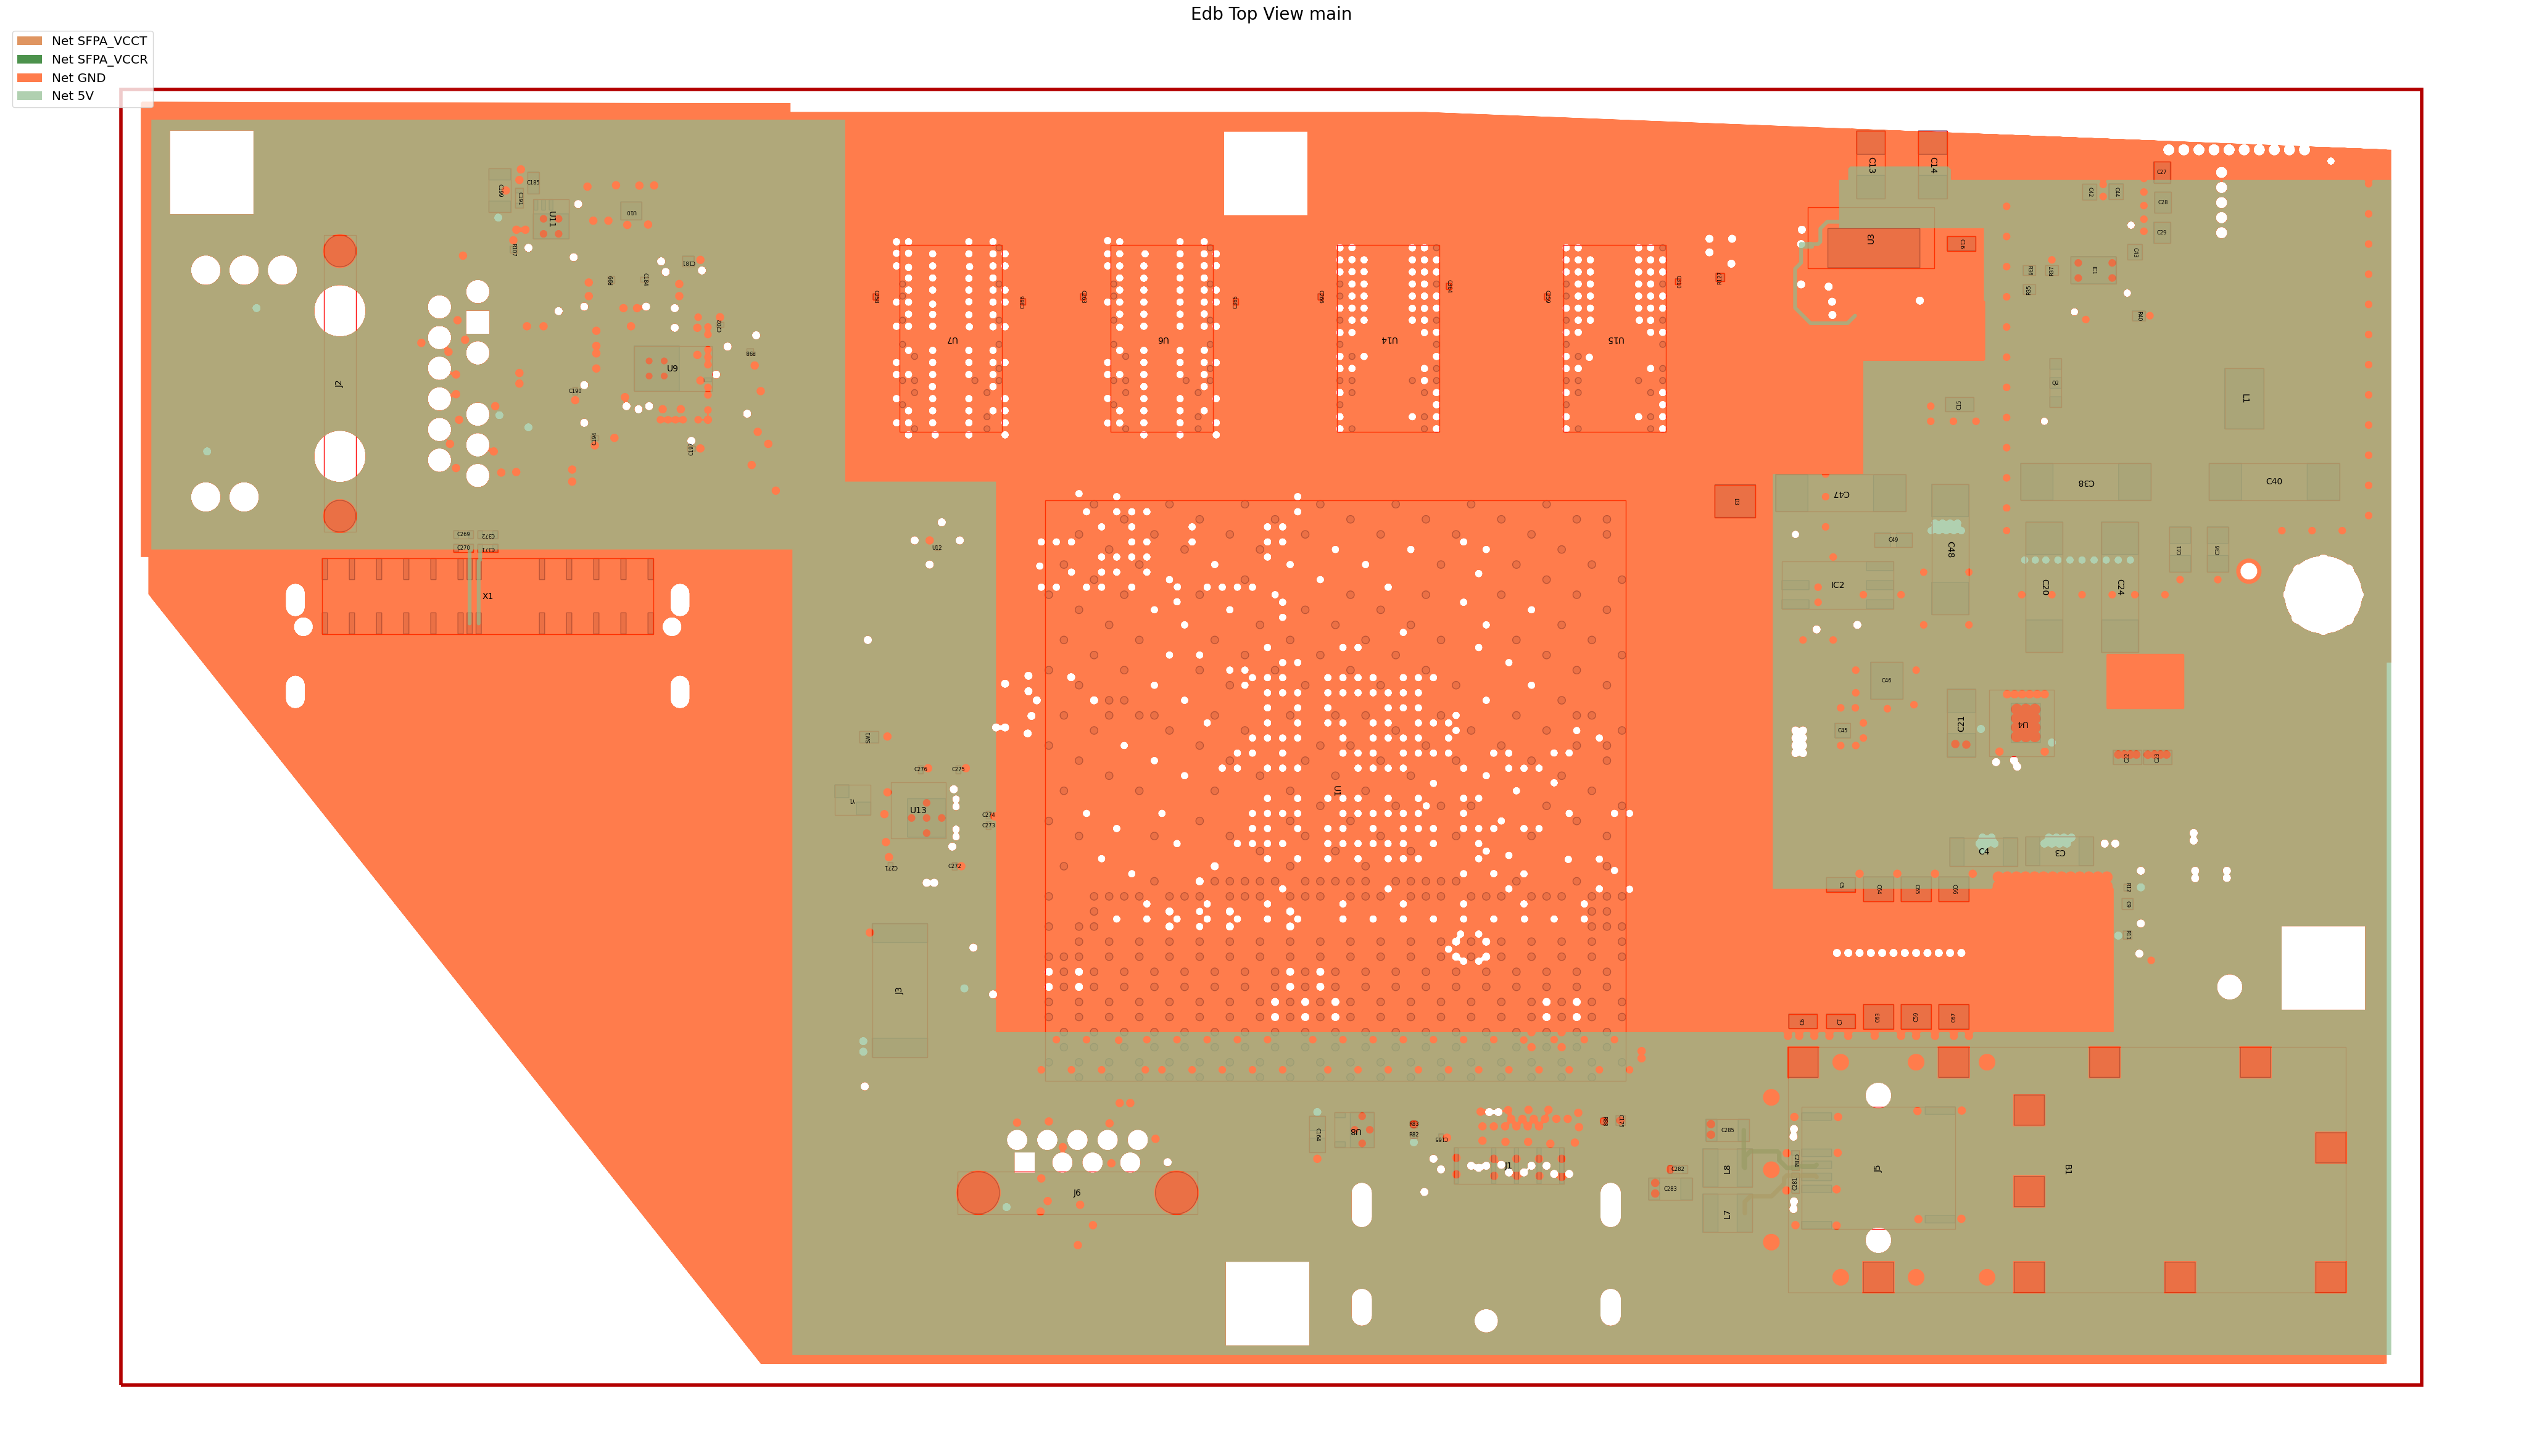

PyEDB INFO: Plot Generation time 6.928


INFO:Edb:Plot Generation time 6.928


(<Figure size 6000x3000 with 1 Axes>,
 <Axes: title={'center': 'Edb Top View main'}>)

In [16]:
# # Load configuration into EDB
edbapp.nets.plot(None, None, color_by_net=True)

## Save and close EDB

In [17]:
edbapp.save()
edbapp.close()

PyEDB INFO: Save Edb file completed in 0.0791 seconds.


INFO:Edb:Save Edb file completed in 0.0791 seconds.


PyEDB INFO: Close Edb file completed in 0.1266 seconds.


INFO:Edb:Close Edb file completed in 0.1266 seconds.


True

The configured EDB file is saved in the temporary folder.

In [18]:
print(temp_folder.name)

C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys


## Analyze DCIR with SIwave

The HFSS 3D Layout interface to SIwave is used to open the EDB and run the DCIR analysis
using SIwave

### Load EDB into HFSS 3D Layout.

In [19]:
siw = ansys.aedt.core.Hfss3dLayout(
    aedb, version=AEDT_VERSION, non_graphical=NG_MODE, new_desktop=True
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


INFO:Global:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.22.dev0.


INFO:Global:PyAEDT version 0.22.dev0.


PyAEDT INFO: Initializing new Desktop session.


INFO:Global:Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


INFO:Global:Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_ce164790-1728-477b-bac8-7285050ab9d1.log is enabled.


INFO:Global:Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_ce164790-1728-477b-bac8-7285050ab9d1.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


INFO:Global:Log on AEDT is disabled.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


INFO:Global:Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Launching PyAEDT with gRPC plugin.


INFO:Global:Launching PyAEDT with gRPC plugin.


PyAEDT INFO: New AEDT session is starting on gRPC port 56729.


INFO:Global:New AEDT session is starting on gRPC port 56729.


PyAEDT INFO: Electronics Desktop started on gRPC port: 56729 after 11.174027919769287 seconds.


INFO:Global:Electronics Desktop started on gRPC port: 56729 after 11.174027919769287 seconds.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


INFO:Global:AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Ansoft.ElectronicsDesktop.2025.2 version started with process ID 2804.


INFO:Global:Ansoft.ElectronicsDesktop.2025.2 version started with process ID 2804.


PyAEDT INFO: EDB folder C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


INFO:Global:EDB folder C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedb has been imported to project ANSYS-HSD_V1


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Active Design set to 0;main


INFO:Global:Active Design set to 0;main


PyAEDT INFO: Aedt Objects correctly read


INFO:Global:Aedt Objects correctly read


### Analyze

In [20]:
siw.analyze(cores=NUM_CORES)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


INFO:Global:Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


INFO:Global:Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 1.0m 0.0s


INFO:Global:Design setup None solved correctly in 0.0h 1.0m 0.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


INFO:Global:Key Desktop/ActiveDSOConfigurations/HFSS 3D Layout Design correctly changed.


True

### Get DC IR results

In [21]:
siw.get_dcir_element_data_current_source("siwave_dc")

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedt.


INFO:Global:Parsing C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


INFO:Global:File C:\Users\ansys\AppData\Local\Temp\tmp8uhc3uge.ansys\edb\ANSYS-HSD_V1.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.28562116622924805


INFO:Global:aedt file load time 0.28562116622924805


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


INFO:Global:PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Loading Modeler.


INFO:Global:Loading Modeler.


PyAEDT INFO: Modeler loaded.


INFO:Global:Modeler loaded.


PyAEDT INFO: EDB loaded.


INFO:Global:EDB loaded.


PyAEDT INFO: Layers loaded.


INFO:Global:Layers loaded.


PyAEDT INFO: Primitives loaded.


INFO:Global:Primitives loaded.


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 0sec


INFO:Global:Modeler class has been initialized! Elapsed time: 0m 0sec


PyEDB INFO: Star initializing Edb 05:26:59.521925


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\pyedb\generic\design_types.py:301: UserWarning: Your ANSYS AEDT version is eligible to gRPC version.You might consider switching to that version for better user experience.For more information please check this link: https://edb.docs.pyansys.com/version/dev/grpc_api/index.html
  warnings.warn(GRPC_GENERAL_WARNING, UserWarning)
INFO:Edb:Star initializing Edb 05:26:59.521925


PyEDB INFO: Edb version 2025.2


INFO:Edb:Edb version 2025.2


PyEDB INFO: Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


INFO:Edb:Logger is initialized. Log file is saved to C:\Users\ansys\AppData\Local\Temp\pyedb_ansys.log.


PyEDB INFO: legacy v0.61.0


INFO:Edb:legacy v0.61.0


PyEDB INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


INFO:Edb:Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]


PyEDB INFO: Database ANSYS-HSD_V1.aedb Opened in 2025.2


INFO:Edb:Database ANSYS-HSD_V1.aedb Opened in 2025.2


PyEDB INFO: Cell main Opened


INFO:Edb:Cell main Opened


PyEDB INFO: Builder was initialized.


INFO:Edb:Builder was initialized.


PyEDB INFO: open_edb completed in 0.2540 seconds.


INFO:Edb:open_edb completed in 0.2540 seconds.


PyEDB INFO: EDB initialization completed in 0.2698 seconds.


INFO:Edb:EDB initialization completed in 0.2698 seconds.


PyAEDT INFO: Solution Data Correctly Loaded.


INFO:Global:Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.012017011642456055


Voltage
J5_VCCR  4.934557
J5_VCCT  4.934436

## Release AEDT

In [22]:
siw.save_project()
siw.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project ANSYS-HSD_V1 Saved correctly


INFO:Global:Project ANSYS-HSD_V1 Saved correctly


PyAEDT INFO: Desktop has been released and closed.


INFO:Global:Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [23]:
temp_folder.cleanup()